# Hyperparameter Tuning

In [247]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import datetime

In [64]:
df = pd.read_csv("Cleaned_Data.csv",index_col=0)
df['DateTime'] = pd.to_datetime(df['DateTime'])


In [65]:
import json
with open("features_pps.json") as write_file:
    features = json.load(write_file)
features.append("DateTime")

In [66]:
df = df[features]

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class RNN_Transform_Wrap(BaseEstimator, TransformerMixin):
    @staticmethod
    def _conv_3d_to_2d(X):
        if X is None:
            return None
        if X.ndim == 2: # Need to expand single variable
            X = np.expand_dims(X, 2)
        return np.vstack([np.squeeze(x, 0) for x in np.vsplit(X, X.shape[0])])

    @staticmethod
    def _conv_2d_to_3d(X, n_timesteps):
        if X is None:
            return None
        return np.vstack([np.expand_dims(x, 0) for x in np.vsplit(X, X.shape[0]/n_timesteps)])

    def __init__(self, transformer, *args, **kwargs):
        self.transformer = transformer(*args, **kwargs)
       
    def get_params(self, deep=True):
        out = self.transformer.get_params(deep=deep)
        out['transformer'] = self.transformer.__class__
        return out
   
    def set_params(self, **params):
        self.transformer = params.pop('transformer', None)()
        self.transformer.set_params(**params)
        return self

    def transform(self, X, *args, **kwargs):
        n_timesteps = X.shape[1]
        out = self.transformer.transform(self._conv_3d_to_2d(X), *args, **kwargs)
        return self._conv_2d_to_3d(out, n_timesteps)
   
    def inverse_transform(self, X, *args, **kwargs):
        n_timesteps = X.shape[1]
        out = self.transformer.inverse_transform(self._conv_3d_to_2d(X), *args, **kwargs)
        return self._conv_2d_to_3d(out, n_timesteps)

    def fit(self, X, y=None, *args, **kwargs):
        self.transformer.fit(self._conv_3d_to_2d(X), self._conv_3d_to_2d(y), *args, **kwargs)
        return self

In [164]:
def data_loading(df,features,class_balance=0.5,lookback=60,horizon=30,test_split=0.2):

    max_t = df["DateTime"].max()
    df_window = df[df["DateTime"]<=(max_t-datetime.timedelta(0,lookback+horizon))]

    start_times = pd.to_datetime(df_window.iloc[::lookback, :]["DateTime"]).reset_index(drop=True)#.values

    tack_df = pd.DataFrame({"StartTime":[0]*len(start_times),"Tacking":[0]*len(start_times)})

    for i, times in enumerate(start_times):
        tack_df.loc[i,"StartTime"] = times
        tack = df[df["DateTime"]==(times+datetime.timedelta(0,lookback+horizon))]["Tacking"].values[0]
        tack_df.loc[i,"Tacking"] = tack

    tacking_yes = tack_df[tack_df["Tacking"]==1].reset_index(drop=True)
    start_tacking_yes = tacking_yes["StartTime"]

    n_noTack = round(len(tacking_yes)*class_balance/(1-class_balance))
    tacking_no = tack_df[tack_df["Tacking"]==0].sample(n_noTack).reset_index(drop=True)
    start_tacking_no = tacking_no["StartTime"]
    
    tacking_no_testSet = tack_df[(tack_df["Tacking"]==0)&(-tack_df["StartTime"].isin(start_tacking_no))].reset_index(drop=True)
    start_tacking_no_test = tacking_no_testSet["StartTime"]

    tacking_all_df = pd.concat([tacking_yes,tacking_no]).reset_index(drop=True)

    X_ones = np.zeros((lookback+1,len(features)-2,len(start_tacking_yes)))
    y_ones = np.ones(len(start_tacking_yes))

    for i,times in enumerate(start_tacking_yes):
        case = df[(df["DateTime"]>=times)
                  &(df["DateTime"]<=times+datetime.timedelta(0,lookback))
                 ].drop(columns=["DateTime","Tacking"]).to_numpy()
        X_ones[:,:,i] = case

    X_ones = X_ones.transpose((2, 0, 1))

    X_zeros = np.zeros((lookback+1,len(features)-2,len(start_tacking_no)))
    y_zeros = np.zeros(len(start_tacking_no))

    for i,times in enumerate(start_tacking_no):
        case = df[(df["DateTime"]>=times)
                  &(df["DateTime"]<=times+datetime.timedelta(0,lookback))
                 ].drop(columns=["DateTime","Tacking"]).to_numpy()
        X_zeros[:,:,i] = case

    X_zeros = X_zeros.transpose((2, 0, 1))

    X = np.vstack((X_zeros,X_ones))
    y = np.hstack((y_zeros,y_ones))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

    x_scaler = RNN_Transform_Wrap(MinMaxScaler)
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    X_noTack_massTest = np.zeros((lookback+1,len(features)-2,len(start_tacking_no_test)))
    y_noTack_massTest = np.zeros(len(start_tacking_no_test))

    for i,times in enumerate(start_tacking_no_test):
        case = df[(df["DateTime"]>=times)
                  &(df["DateTime"]<=times+datetime.timedelta(0,lookback))
                 ].drop(columns=["DateTime","Tacking"]).to_numpy()
        X_noTack_massTest[:,:,i] = case

    X_noTack_massTest = X_noTack_massTest.transpose((2, 0, 1))
    X_noTack_massTest = x_scaler.transform(X_noTack_massTest)
    
    return X_train, X_test, y_train, y_test, X_noTack_massTest, y_noTack_massTest


In [184]:
%reload_ext tensorboard
#!rm -rf ./logs/
from tensorboard.plugins.hparams import api as hp

In [206]:
HP_LR = hp.HParam('learning_rate', hp.Discrete([0.01, 0.001, 0.0001]))
HP_LOOKBACK = hp.HParam('lookback', hp.Discrete([30, 60, 90]))
HP_HORIZON = hp.HParam('horizon', hp.Discrete([10, 30]))
HP_BATCH = hp.HParam('batch', hp.Discrete([1]))
HP_INPUT = hp.HParam('input_lstm', hp.Discrete([16, 32]))
HP_OUTPUT = hp.HParam('output_output', hp.Discrete([64, 128]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_LR, HP_LOOKBACK, HP_HORIZON, HP_INPUT, HP_OUTPUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [208]:
def train_test_model(hparams):

    # Load data
    X_train, X_test, y_train, y_test, X_noTack_massTest, y_noTack_massTest = data_loading(df,features,
                    class_balance=0.5,lookback=hparams[HP_LOOKBACK],horizon=hparams[HP_HORIZON],test_split=0.2)    
    # Build Model
    ## Input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]),name="input_layer")

    ## Stacked LSTMs
    x = Bidirectional(LSTM(hparams[HP_INPUT],activation="tanh",recurrent_activation="sigmoid",return_sequences=True), 
                      merge_mode="ave")(input_layer)
    x = Bidirectional(LSTM(hparams[HP_OUTPUT],activation="tanh",recurrent_activation="sigmoid",return_sequences=False), 
                      merge_mode="ave")(x)

    ## Dense and output
    x = Dense(hparams[HP_OUTPUT],activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    
    model = Model(input_layer, outputs, name="model")
    model.summary()

    
    opt = Adam(hparams[HP_LR])
    model.compile(opt, loss="binary_crossentropy", metrics= 'accuracy' )
    
    #callback = EarlyStopping(monitor='val_accuracy', mode="max", patience=20, restore_best_weights=True)
    checkpoint = ModelCheckpoint("models/stacked_noslide/best_model.h5", monitor='val_accuracy', save_best_only=True,
                                 save_weights_only=True, mode='max')
    
    history = model.fit(X_train, y_train, batch_size = 1, epochs = 40, 
                        validation_split = 0.1,callbacks = [checkpoint])
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    loss,accuracy = model.evaluate(X_test,y_test)
    return accuracy

In [209]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

--- Starting trial: run-0
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41472     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
_________________________________________________________________
E

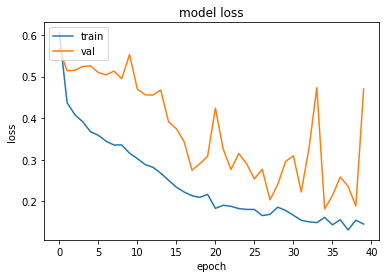

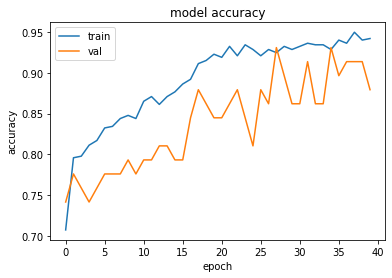

5/5 [==============================] - 0s 6ms/step - loss: 0.4735 - accuracy: 0.8552
--- Starting trial: run-1
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               148480    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

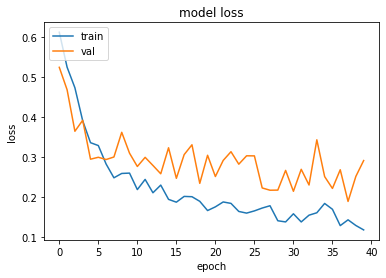

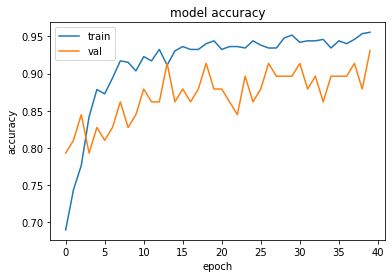

5/5 [==============================] - 0s 8ms/step - loss: 0.1608 - accuracy: 0.9379
--- Starting trial: run-2
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

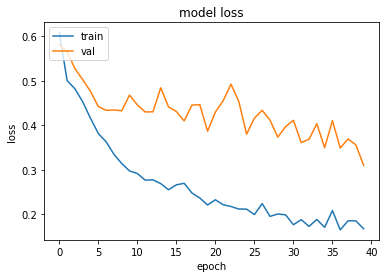

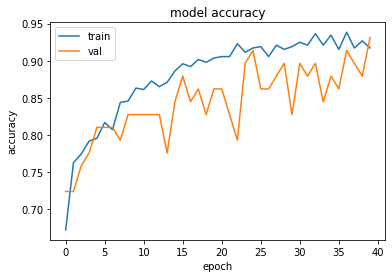

5/5 [==============================] - 0s 5ms/step - loss: 0.2049 - accuracy: 0.9310
--- Starting trial: run-3
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

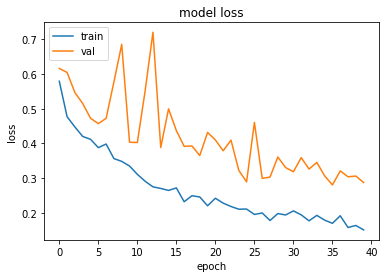

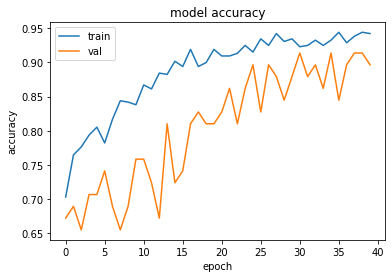

5/5 [==============================] - 0s 8ms/step - loss: 0.2262 - accuracy: 0.9172
--- Starting trial: run-4
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tr

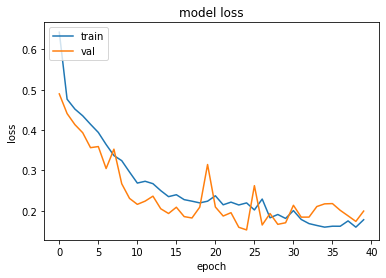

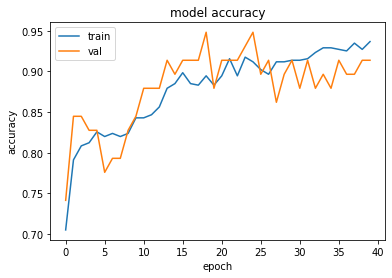

5/5 [==============================] - 0s 5ms/step - loss: 0.2099 - accuracy: 0.9178
--- Starting trial: run-5
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

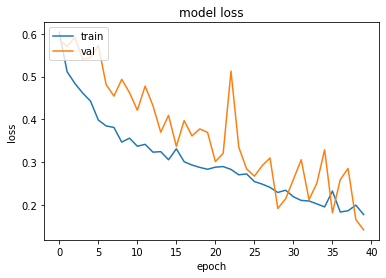

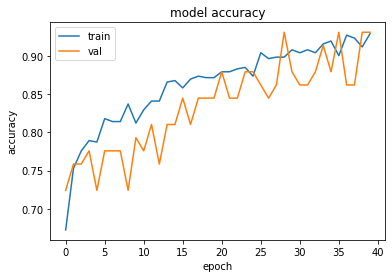

5/5 [==============================] - 0s 7ms/step - loss: 0.1600 - accuracy: 0.9452
--- Starting trial: run-6
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

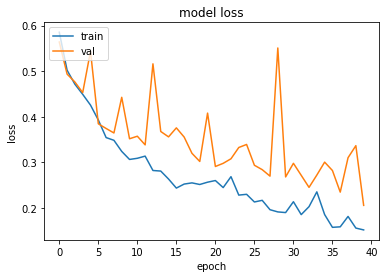

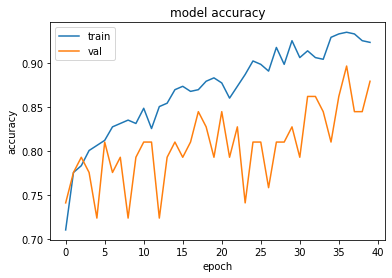

5/5 [==============================] - 0s 5ms/step - loss: 0.1573 - accuracy: 0.9315
--- Starting trial: run-7
{'learning_rate': 0.0001, 'lookback': 30, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

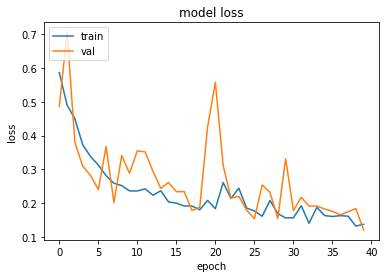

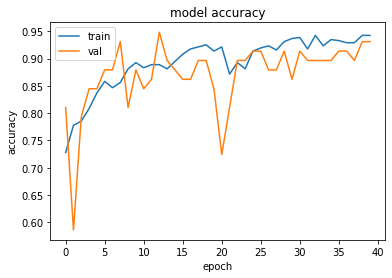

5/5 [==============================] - 0s 7ms/step - loss: 0.1352 - accuracy: 0.9452
--- Starting trial: run-8
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tr

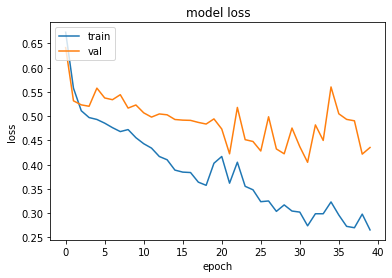

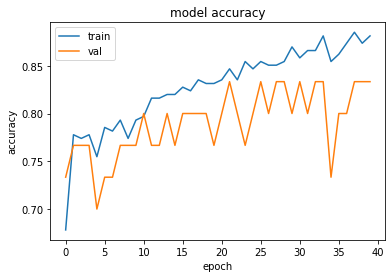

3/3 [==============================] - 0s 7ms/step - loss: 0.4256 - accuracy: 0.8219
--- Starting trial: run-9
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

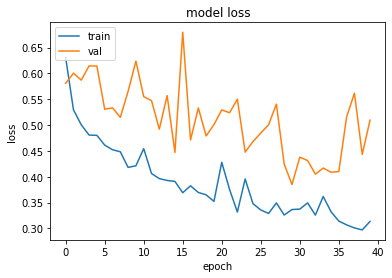

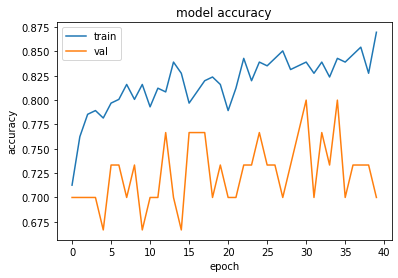

3/3 [==============================] - 0s 9ms/step - loss: 0.5167 - accuracy: 0.7671
--- Starting trial: run-10
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-t

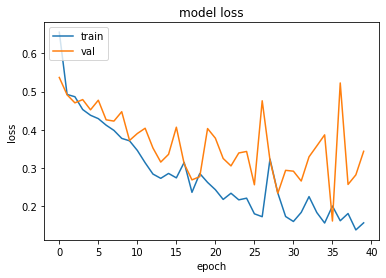

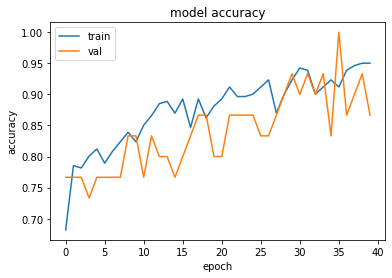

3/3 [==============================] - 0s 7ms/step - loss: 0.3028 - accuracy: 0.9041
--- Starting trial: run-11
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
No

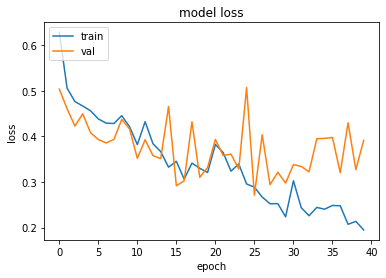

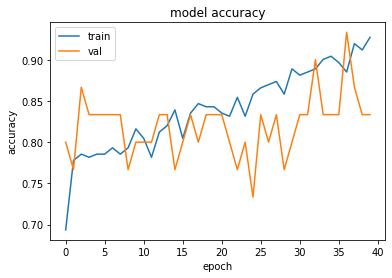

3/3 [==============================] - 0s 9ms/step - loss: 0.3091 - accuracy: 0.9041
--- Starting trial: run-12
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-t

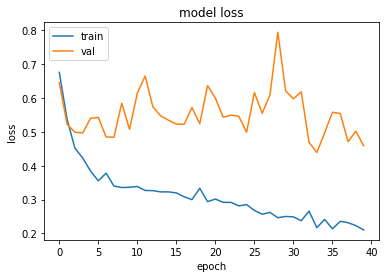

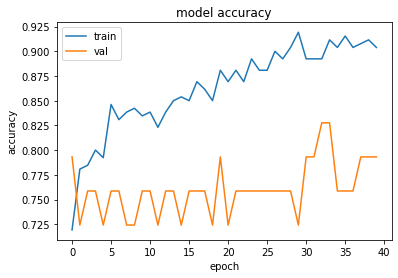

3/3 [==============================] - 0s 7ms/step - loss: 0.4436 - accuracy: 0.8082
--- Starting trial: run-13
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
No

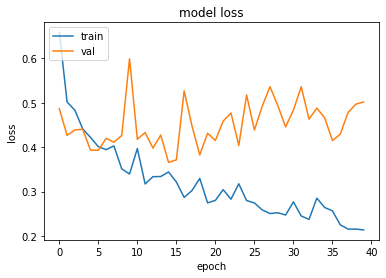

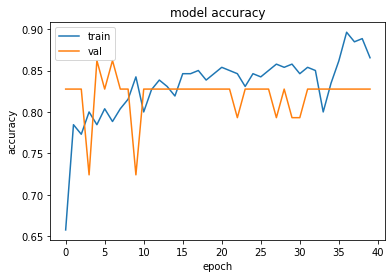

3/3 [==============================] - 0s 9ms/step - loss: 0.1857 - accuracy: 0.9315
--- Starting trial: run-14
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-t

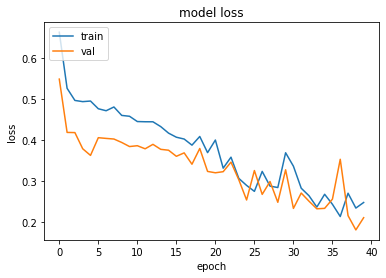

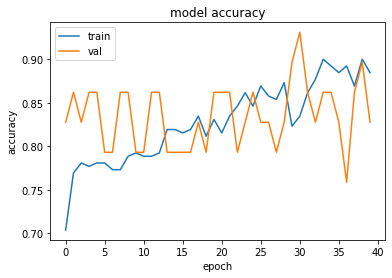

3/3 [==============================] - 0s 7ms/step - loss: 0.2675 - accuracy: 0.8630
--- Starting trial: run-15
{'learning_rate': 0.0001, 'lookback': 60, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
No

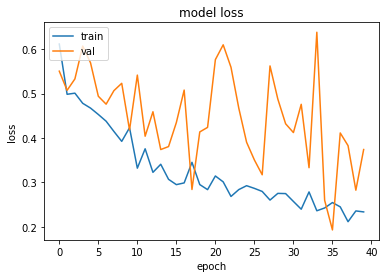

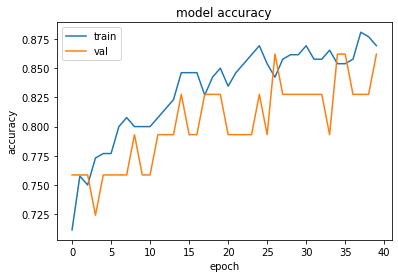

3/3 [==============================] - 0s 9ms/step - loss: 0.4591 - accuracy: 0.8493
--- Starting trial: run-16
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-t

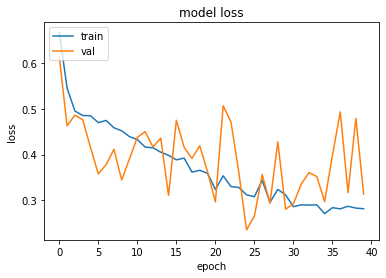

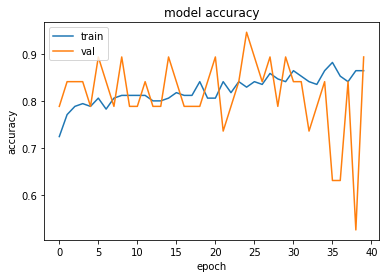

2/2 [==============================] - 0s 7ms/step - loss: 0.3226 - accuracy: 0.8125
--- Starting trial: run-17
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
No

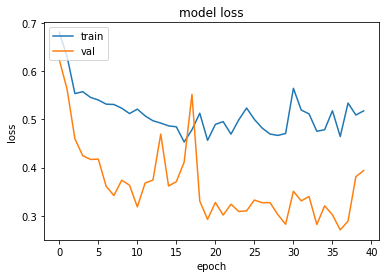

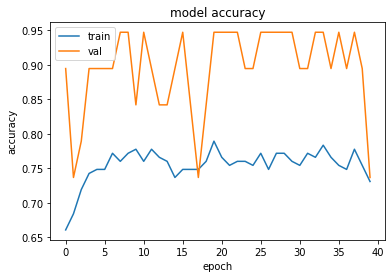

2/2 [==============================] - 0s 8ms/step - loss: 0.4371 - accuracy: 0.7708
--- Starting trial: run-18
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-t

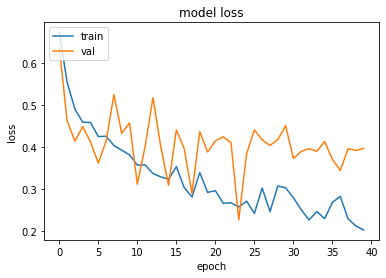

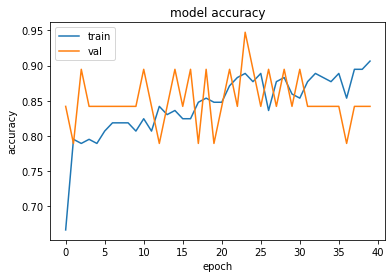

2/2 [==============================] - 0s 6ms/step - loss: 0.4012 - accuracy: 0.7917
--- Starting trial: run-19
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
No

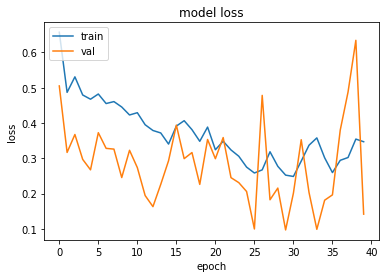

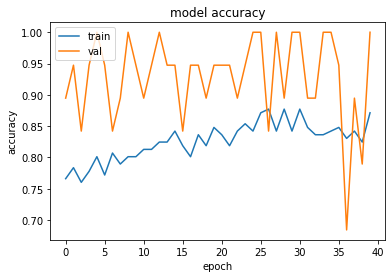

2/2 [==============================] - 0s 9ms/step - loss: 0.3675 - accuracy: 0.7917
--- Starting trial: run-20
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-t

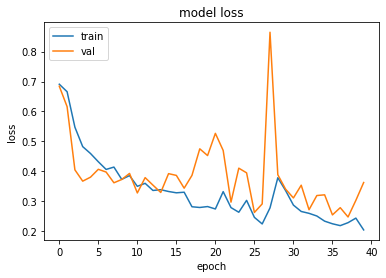

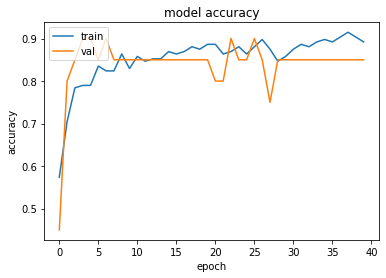

2/2 [==============================] - 0s 7ms/step - loss: 0.4056 - accuracy: 0.8200
--- Starting trial: run-21
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
No

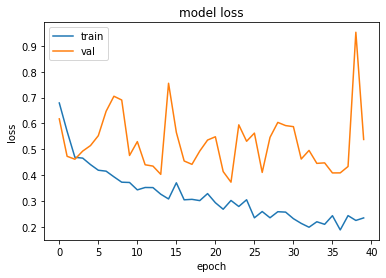

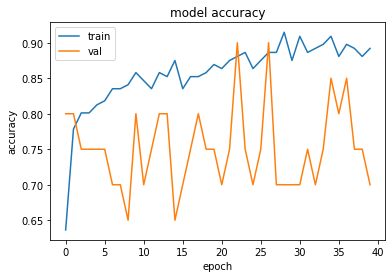

2/2 [==============================] - 0s 9ms/step - loss: 0.2791 - accuracy: 0.8400
--- Starting trial: run-22
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_50 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-t

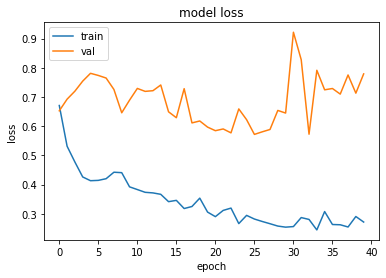

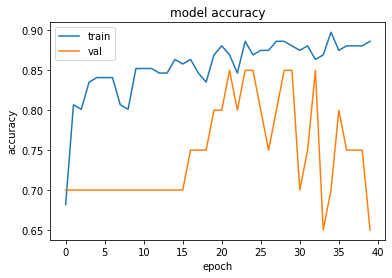

2/2 [==============================] - 0s 7ms/step - loss: 0.4342 - accuracy: 0.8000
--- Starting trial: run-23
{'learning_rate': 0.0001, 'lookback': 90, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
No

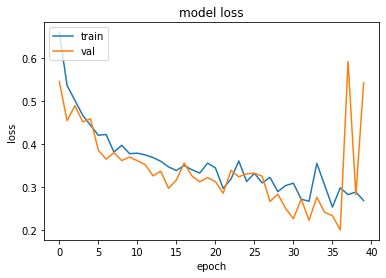

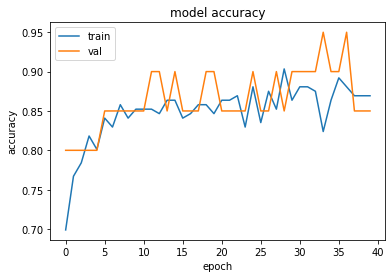

2/2 [==============================] - 0s 9ms/step - loss: 0.6091 - accuracy: 0.8000
--- Starting trial: run-24
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_54 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tr

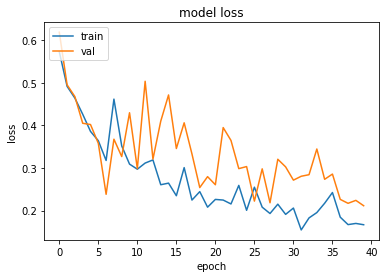

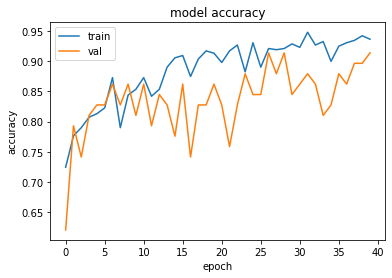

5/5 [==============================] - 0s 5ms/step - loss: 0.1880 - accuracy: 0.9103
--- Starting trial: run-25
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

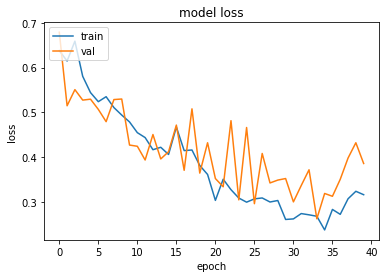

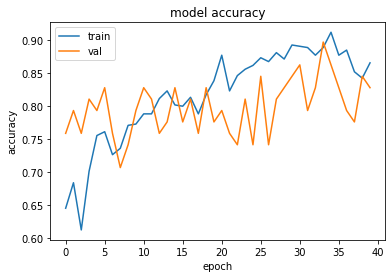

5/5 [==============================] - 0s 7ms/step - loss: 0.3333 - accuracy: 0.8828
--- Starting trial: run-26
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_58 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

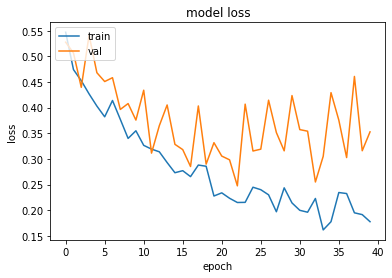

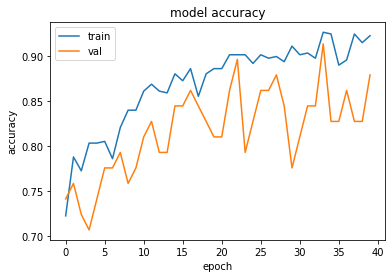

5/5 [==============================] - 0s 5ms/step - loss: 0.2498 - accuracy: 0.9103
--- Starting trial: run-27
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_60 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

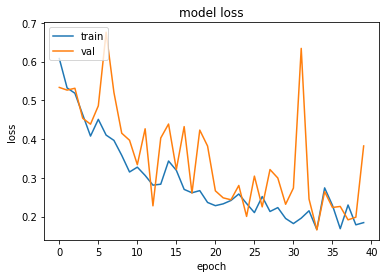

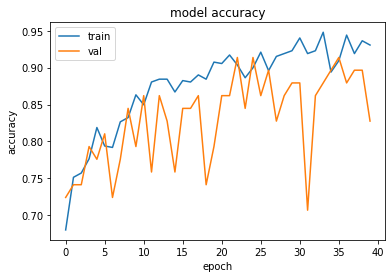

5/5 [==============================] - 0s 10ms/step - loss: 0.3118 - accuracy: 0.8828
--- Starting trial: run-28
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-t

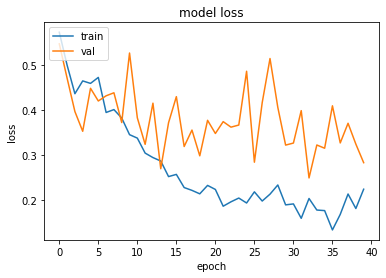

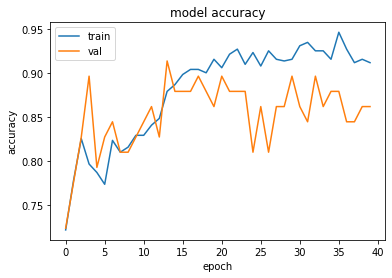

5/5 [==============================] - 0s 5ms/step - loss: 0.2021 - accuracy: 0.9247
--- Starting trial: run-29
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_65 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

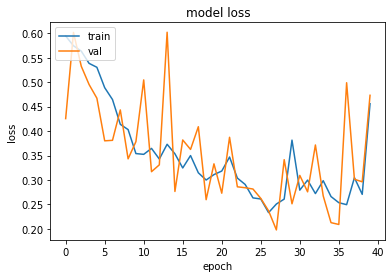

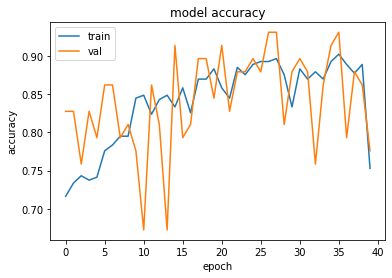

5/5 [==============================] - 0s 7ms/step - loss: 0.4648 - accuracy: 0.8082
--- Starting trial: run-30
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_66 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_67 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

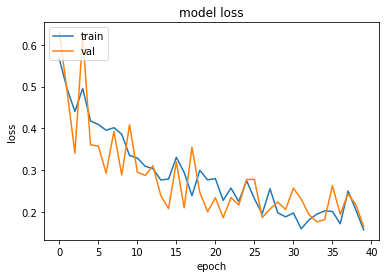

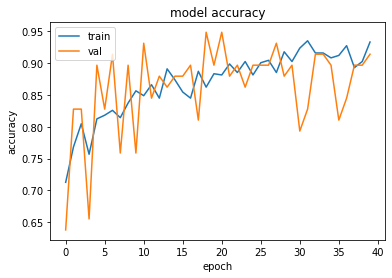

5/5 [==============================] - 0s 5ms/step - loss: 0.2428 - accuracy: 0.9041
--- Starting trial: run-31
{'learning_rate': 0.001, 'lookback': 30, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

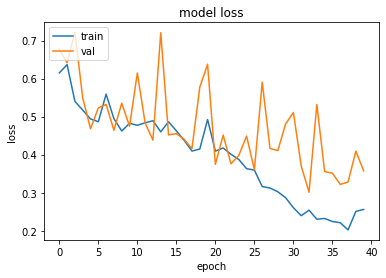

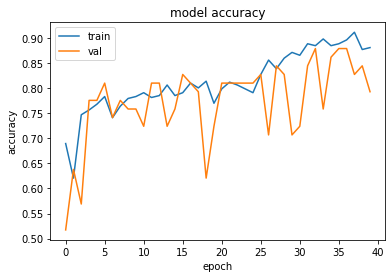

5/5 [==============================] - 0s 7ms/step - loss: 0.2713 - accuracy: 0.8904
--- Starting trial: run-32
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_70 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_70 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tr

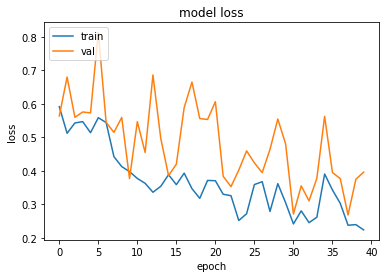

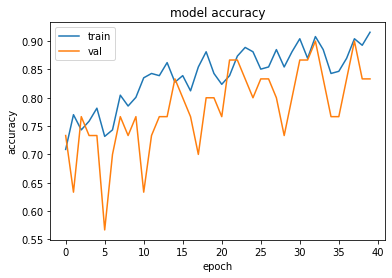

3/3 [==============================] - 0s 7ms/step - loss: 0.5045 - accuracy: 0.8082
--- Starting trial: run-33
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_73 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

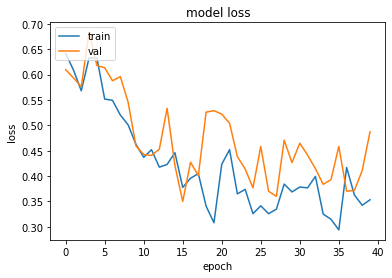

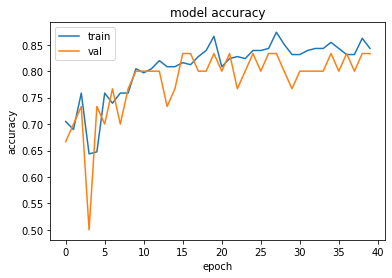

3/3 [==============================] - 0s 9ms/step - loss: 0.5317 - accuracy: 0.8219
--- Starting trial: run-34
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_74 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_75 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_74 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

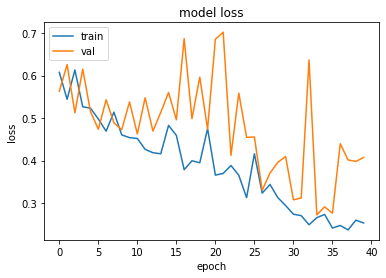

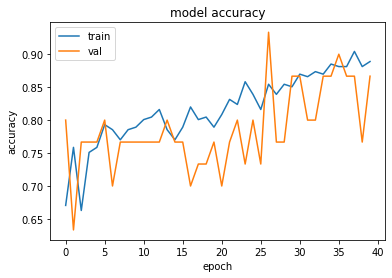

3/3 [==============================] - 0s 7ms/step - loss: 0.2919 - accuracy: 0.8493
--- Starting trial: run-35
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_76 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_77 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_76 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

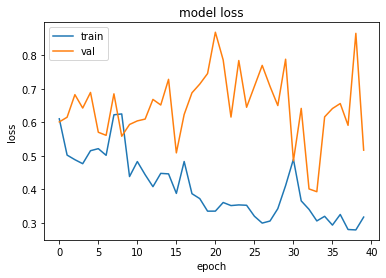

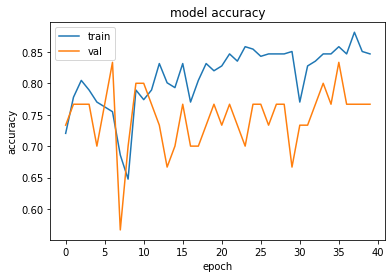

3/3 [==============================] - 0s 9ms/step - loss: 0.2965 - accuracy: 0.8356
--- Starting trial: run-36
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_78 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_79 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_78 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tr

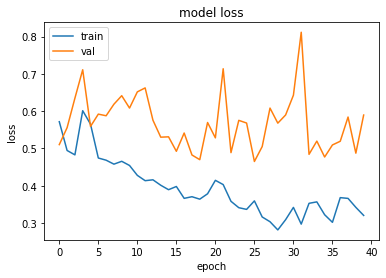

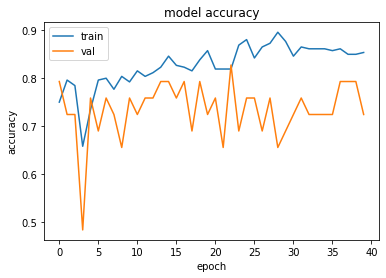

3/3 [==============================] - 0s 7ms/step - loss: 0.4221 - accuracy: 0.7260
--- Starting trial: run-37
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_80 (Bidirectio (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_81 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_80 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

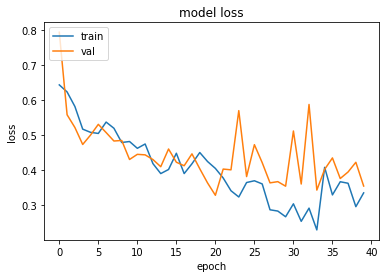

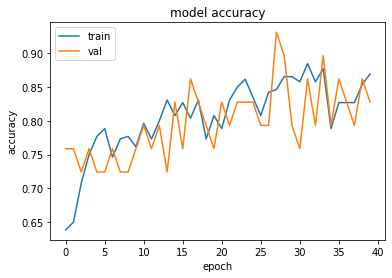

3/3 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.8356
--- Starting trial: run-38
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_82 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_83 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_82 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

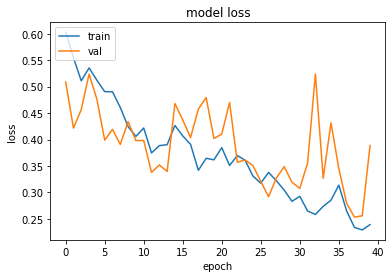

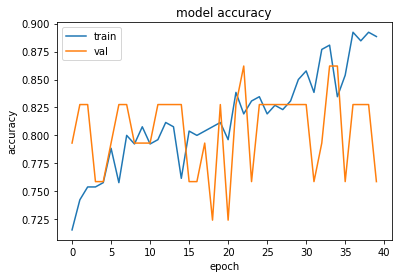

3/3 [==============================] - 0s 7ms/step - loss: 0.2102 - accuracy: 0.8904
--- Starting trial: run-39
{'learning_rate': 0.001, 'lookback': 60, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_84 (Bidirectio (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_85 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_84 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

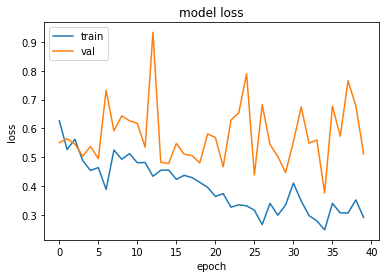

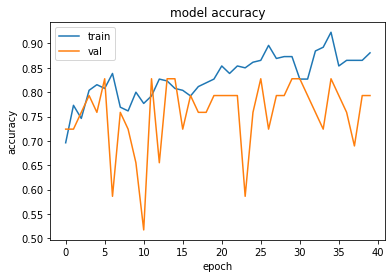

3/3 [==============================] - 0s 10ms/step - loss: 0.2870 - accuracy: 0.8767
--- Starting trial: run-40
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_86 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_87 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_86 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-t

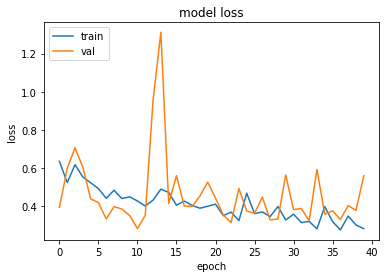

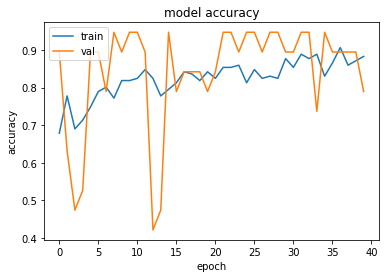

2/2 [==============================] - 0s 7ms/step - loss: 0.4201 - accuracy: 0.8333
--- Starting trial: run-41
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_88 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_89 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_88 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

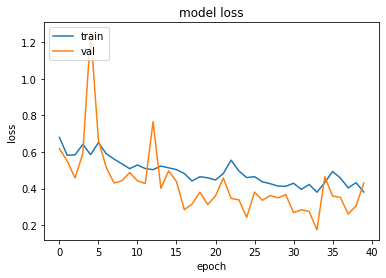

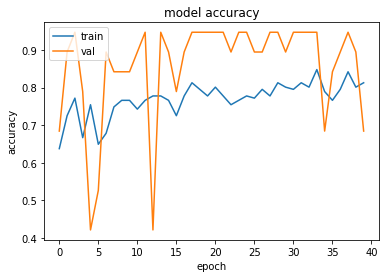

2/2 [==============================] - 0s 9ms/step - loss: 0.4714 - accuracy: 0.7708
--- Starting trial: run-42
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_90 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_91 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_90 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

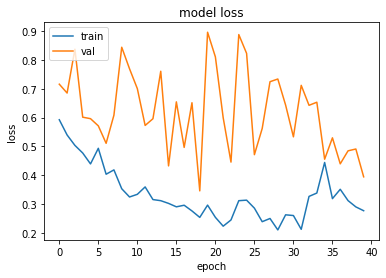

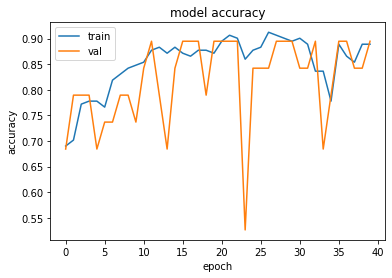

2/2 [==============================] - 0s 7ms/step - loss: 0.5025 - accuracy: 0.8125
--- Starting trial: run-43
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_92 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_93 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_92 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

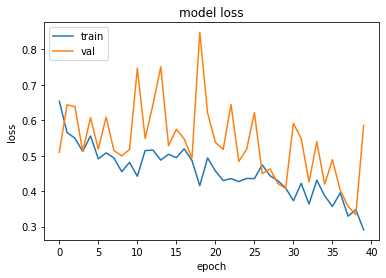

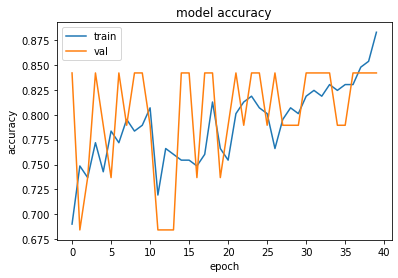

2/2 [==============================] - 0s 8ms/step - loss: 0.5865 - accuracy: 0.6875
--- Starting trial: run-44
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_94 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_95 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_94 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tr

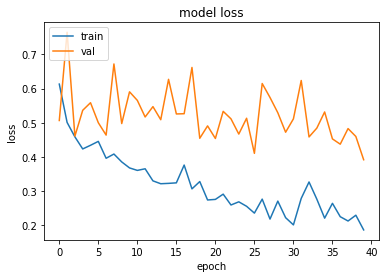

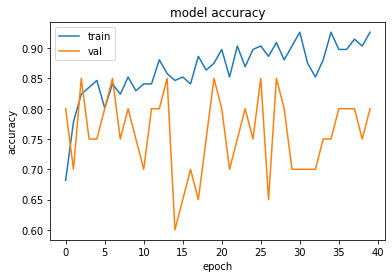

2/2 [==============================] - 0s 6ms/step - loss: 0.3291 - accuracy: 0.8200
--- Starting trial: run-45
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_96 (Bidirectio (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_97 (Bidirectio (None, 128)               148480    
_________________________________________________________________
dense_96 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non

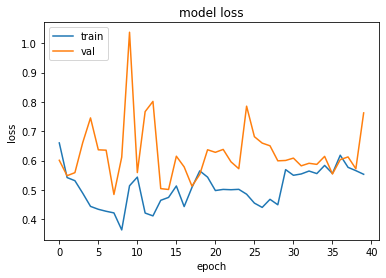

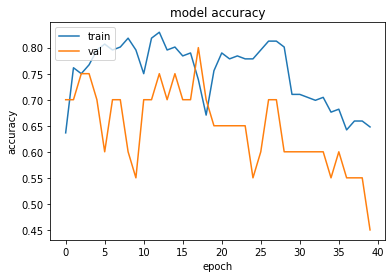

2/2 [==============================] - 0s 9ms/step - loss: 0.6366 - accuracy: 0.5800
--- Starting trial: run-46
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_98 (Bidirectio (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_99 (Bidirectio (None, 64)                49664     
_________________________________________________________________
dense_98 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tr

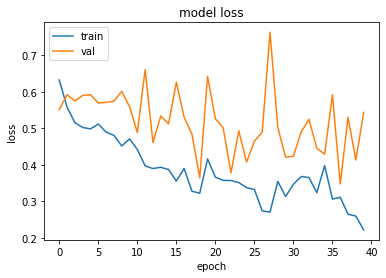

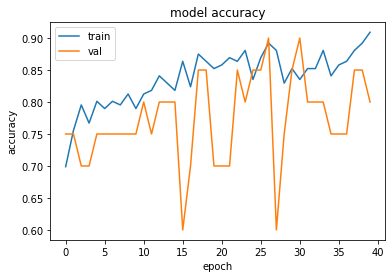

2/2 [==============================] - 0s 7ms/step - loss: 0.3007 - accuracy: 0.8600
--- Starting trial: run-47
{'learning_rate': 0.001, 'lookback': 90, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_100 (Bidirecti (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_101 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_100 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non

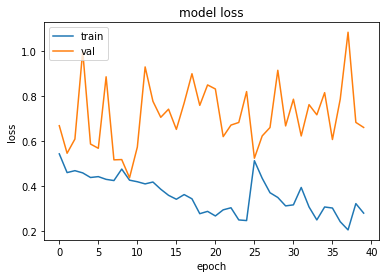

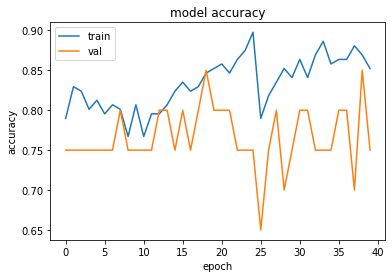

2/2 [==============================] - 0s 9ms/step - loss: 0.3283 - accuracy: 0.8000
--- Starting trial: run-48
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_102 (Bidirecti (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_103 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dense_102 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tra

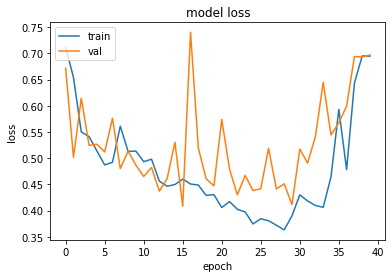

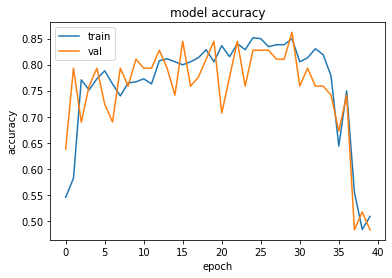

5/5 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.4690
--- Starting trial: run-49
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_104 (Bidirecti (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_105 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_104 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-

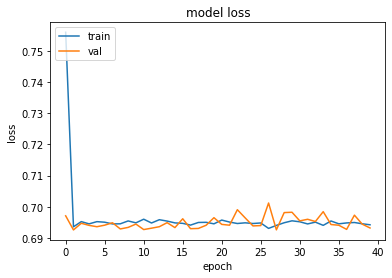

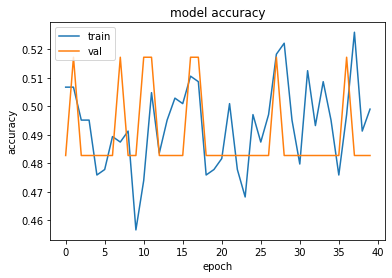

5/5 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4690
--- Starting trial: run-50
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_106 (Bidirecti (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_107 (Bidirecti (None, 64)                49664     
_________________________________________________________________
dense_106 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tra

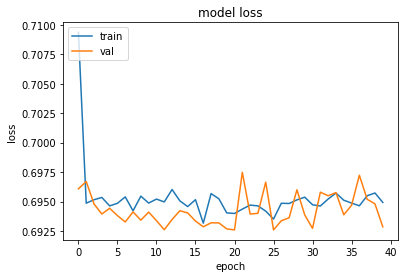

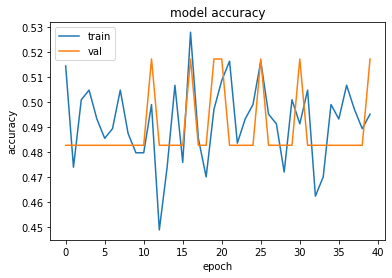

5/5 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5310
--- Starting trial: run-51
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_108 (Bidirecti (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_109 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_108 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non-

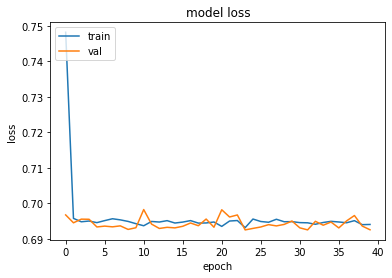

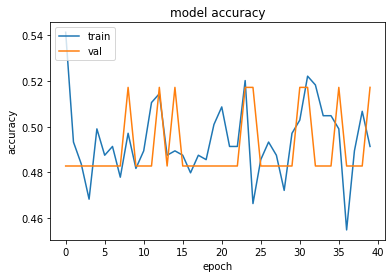

5/5 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5310
--- Starting trial: run-52
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_110 (Bidirecti (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_111 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dense_110 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tra

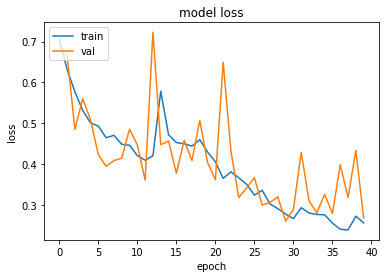

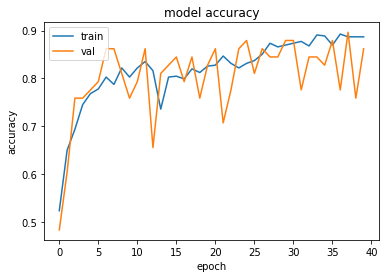

5/5 [==============================] - 0s 5ms/step - loss: 0.2232 - accuracy: 0.9178
--- Starting trial: run-53
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_112 (Bidirecti (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_113 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_112 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-

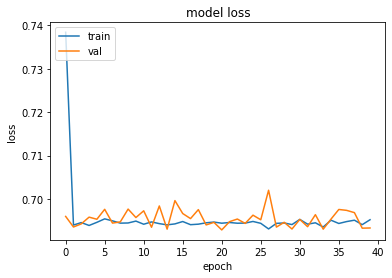

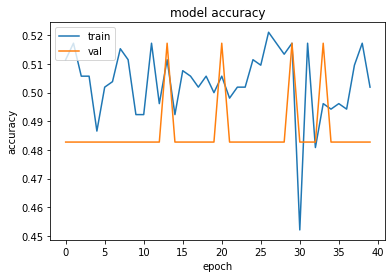

5/5 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4452
--- Starting trial: run-54
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_114 (Bidirecti (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_115 (Bidirecti (None, 64)                49664     
_________________________________________________________________
dense_114 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tra

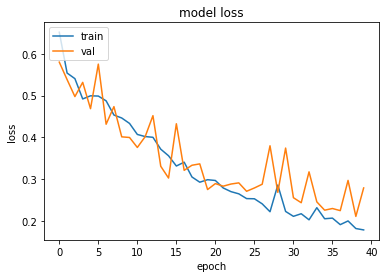

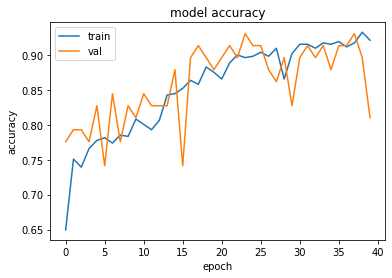

5/5 [==============================] - 0s 5ms/step - loss: 0.2571 - accuracy: 0.8630
--- Starting trial: run-55
{'learning_rate': 0.01, 'lookback': 30, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_116 (Bidirecti (None, 31, 32)            12544     
_________________________________________________________________
bidirectional_117 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_116 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non-

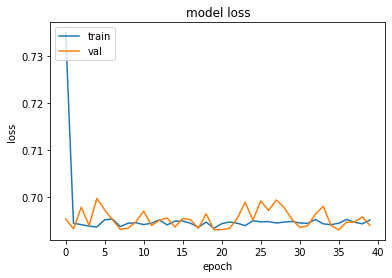

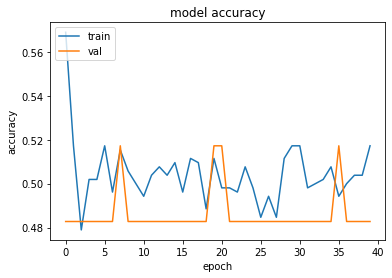

5/5 [==============================] - 0s 7ms/step - loss: 0.6952 - accuracy: 0.4452
--- Starting trial: run-56
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_118 (Bidirecti (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_119 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dense_118 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tra

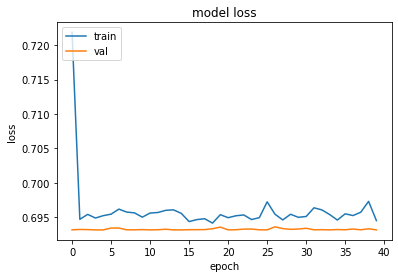

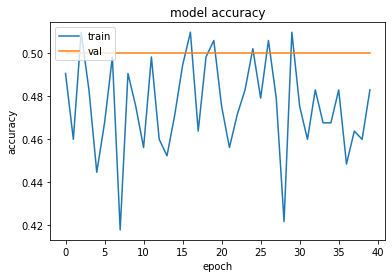

3/3 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4932
--- Starting trial: run-57
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_120 (Bidirecti (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_121 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_120 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-

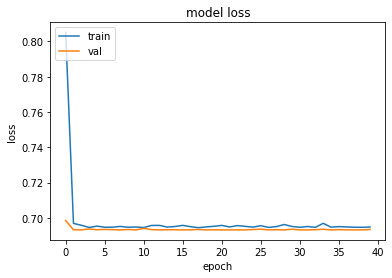

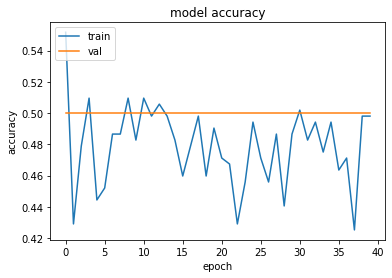

3/3 [==============================] - 0s 9ms/step - loss: 0.6937 - accuracy: 0.4932
--- Starting trial: run-58
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_122 (Bidirecti (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_123 (Bidirecti (None, 64)                49664     
_________________________________________________________________
dense_122 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tra

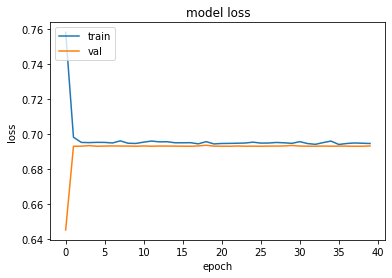

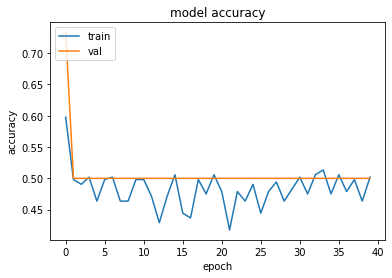

3/3 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4932
--- Starting trial: run-59
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_124 (Bidirecti (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_125 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_124 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non-

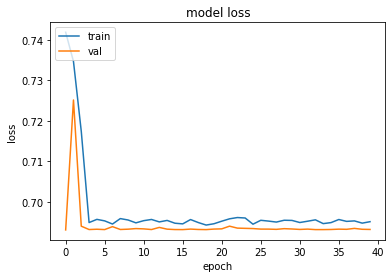

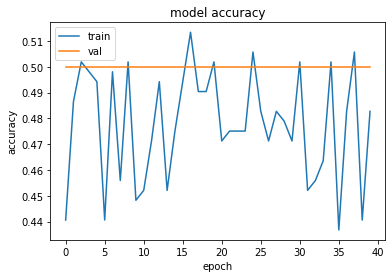

3/3 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.4932
--- Starting trial: run-60
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_126 (Bidirecti (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_127 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dense_126 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tra

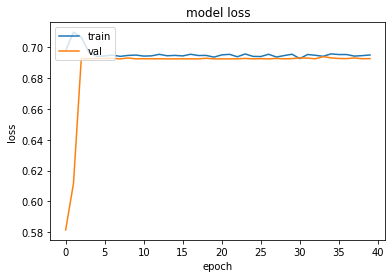

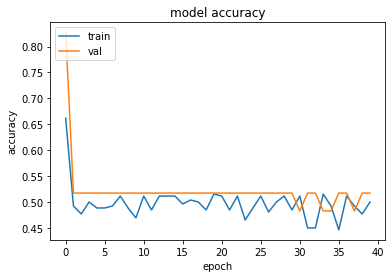

3/3 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.4521
--- Starting trial: run-61
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_128 (Bidirecti (None, 61, 16)            4224      
_________________________________________________________________
bidirectional_129 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_128 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-

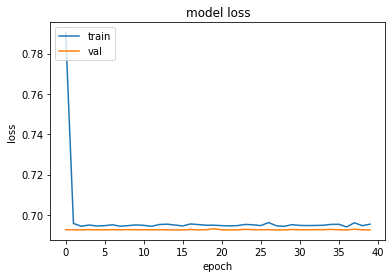

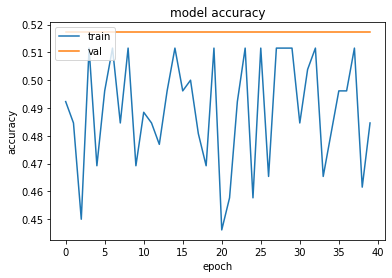

3/3 [==============================] - 0s 9ms/step - loss: 0.6966 - accuracy: 0.4521
--- Starting trial: run-62
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_130 (Bidirecti (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_131 (Bidirecti (None, 64)                49664     
_________________________________________________________________
dense_130 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tra

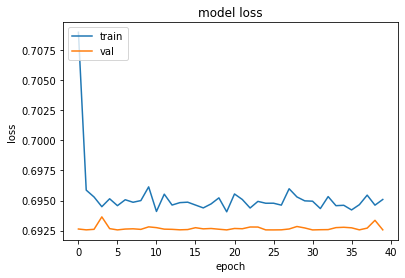

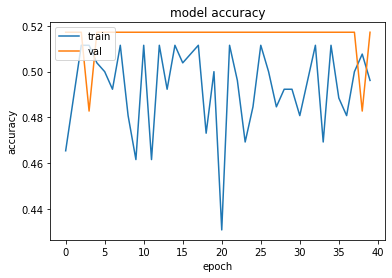

3/3 [==============================] - 0s 7ms/step - loss: 0.6975 - accuracy: 0.4521
--- Starting trial: run-63
{'learning_rate': 0.01, 'lookback': 60, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 61, 16)]          0         
_________________________________________________________________
bidirectional_132 (Bidirecti (None, 61, 32)            12544     
_________________________________________________________________
bidirectional_133 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_132 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non-

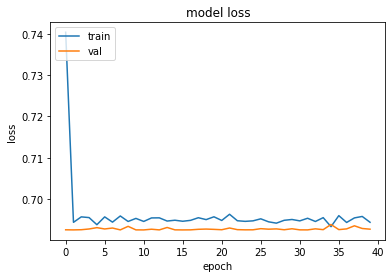

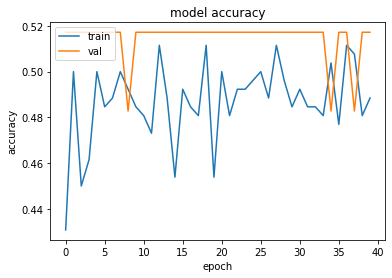

3/3 [==============================] - 0s 9ms/step - loss: 0.6948 - accuracy: 0.4521
--- Starting trial: run-64
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 10, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_134 (Bidirecti (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_135 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dense_134 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tra

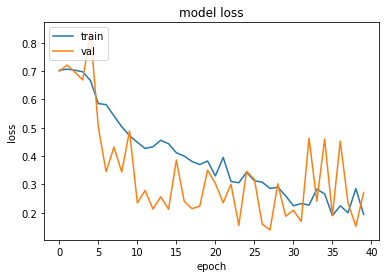

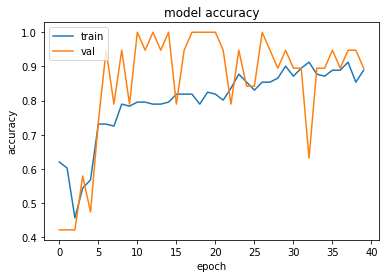

2/2 [==============================] - 0s 7ms/step - loss: 0.3679 - accuracy: 0.8750
--- Starting trial: run-65
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 10, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_136 (Bidirecti (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_137 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_136 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-

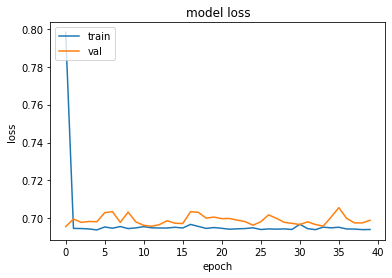

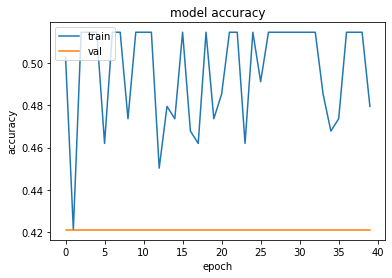

2/2 [==============================] - 0s 9ms/step - loss: 0.6951 - accuracy: 0.4792
--- Starting trial: run-66
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 10, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_138 (Bidirecti (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_139 (Bidirecti (None, 64)                49664     
_________________________________________________________________
dense_138 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tra

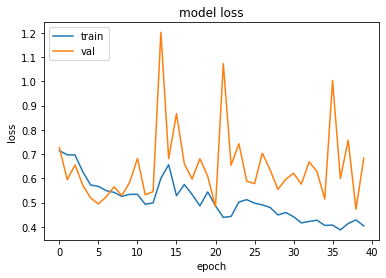

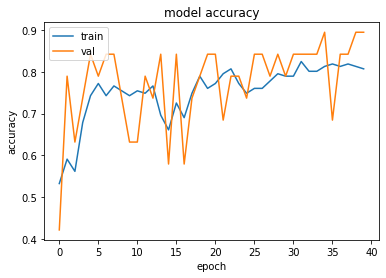

2/2 [==============================] - 0s 7ms/step - loss: 0.3493 - accuracy: 0.8542
--- Starting trial: run-67
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 10, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_140 (Bidirecti (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_141 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_140 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non-

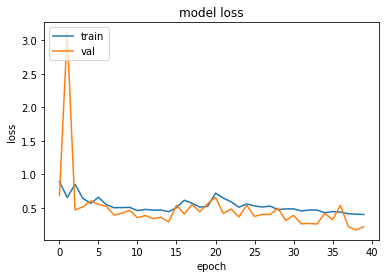

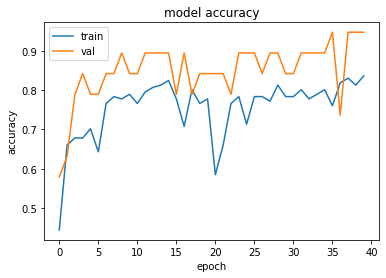

2/2 [==============================] - 0s 9ms/step - loss: 0.3157 - accuracy: 0.8333
--- Starting trial: run-68
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 30, 'input_lstm': 16, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_142 (Bidirecti (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_143 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dense_142 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 65        
Total params: 49,921
Trainable params: 49,921
Non-tra

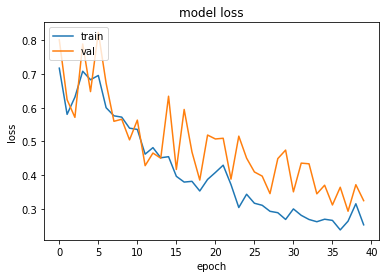

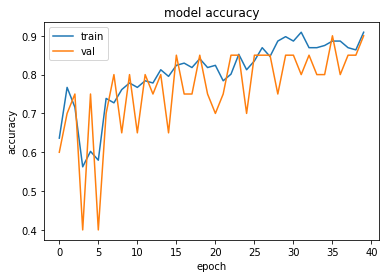

2/2 [==============================] - 0s 6ms/step - loss: 0.3158 - accuracy: 0.8200
--- Starting trial: run-69
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 30, 'input_lstm': 16, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_144 (Bidirecti (None, 91, 16)            4224      
_________________________________________________________________
bidirectional_145 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_144 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-

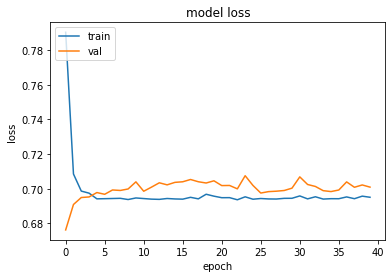

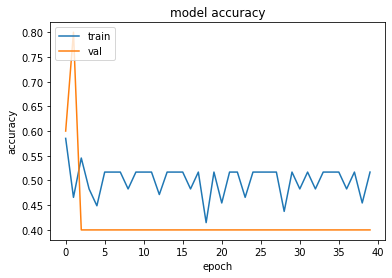

2/2 [==============================] - 0s 8ms/step - loss: 0.6952 - accuracy: 0.4800
--- Starting trial: run-70
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 30, 'input_lstm': 32, 'output_output': 64}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_146 (Bidirecti (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_147 (Bidirecti (None, 64)                49664     
_________________________________________________________________
dense_146 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-tra

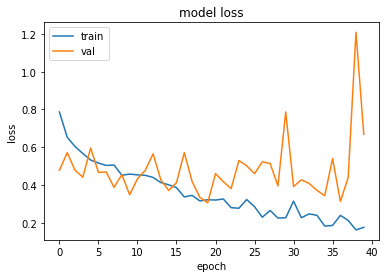

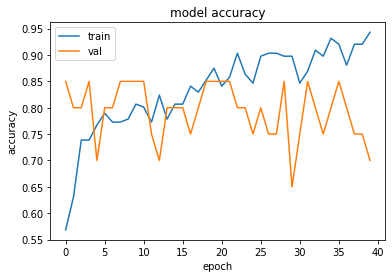

2/2 [==============================] - 0s 7ms/step - loss: 0.4160 - accuracy: 0.7800
--- Starting trial: run-71
{'learning_rate': 0.01, 'lookback': 90, 'horizon': 30, 'input_lstm': 32, 'output_output': 128}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 91, 16)]          0         
_________________________________________________________________
bidirectional_148 (Bidirecti (None, 91, 32)            12544     
_________________________________________________________________
bidirectional_149 (Bidirecti (None, 128)               164864    
_________________________________________________________________
dense_148 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 129       
Total params: 194,049
Trainable params: 194,049
Non-

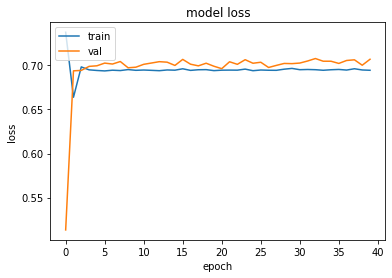

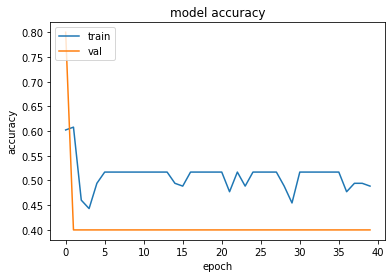

2/2 [==============================] - 0s 8ms/step - loss: 0.6973 - accuracy: 0.4800


In [210]:
session_num = 0

for lr in HP_LR.domain.values:
    for lookback in HP_LOOKBACK.domain.values:
        for horizon in HP_HORIZON.domain.values:
            for input_lstm in HP_INPUT.domain.values:
                for output_lstm in HP_OUTPUT.domain.values:
                    hparams = {
                        HP_LR: lr,
                        HP_LOOKBACK: lookback,
                        HP_HORIZON: horizon,
                        HP_INPUT: input_lstm,
                        HP_OUTPUT: output_lstm}

                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

In [211]:
%tensorboard --logdir logs/hparam_tuning_stacked

Reusing TensorBoard on port 6006 (pid 3777), started 14:10:22 ago. (Use '!kill 3777' to kill it.)

# Run Best Model

In [248]:
X_train, X_test, y_train, y_test, X_noTack_massTest, y_noTack_massTest =  data_loading(
    df,features,class_balance=0.5,lookback=30,horizon=30,test_split=0.2)


In [249]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [250]:
input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]),name="input_layer")

In [251]:
x = Bidirectional(LSTM(16,activation="tanh",recurrent_activation="sigmoid",return_sequences=True), 
                  merge_mode="ave")(input_layer)
x = Bidirectional(LSTM(128,activation="tanh",recurrent_activation="sigmoid",return_sequences=False), 
                  merge_mode="ave")(x)

In [252]:
x = Dense(128,activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

In [253]:
model = Model(input_layer, outputs, name="model")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 31, 16)]          0         
_________________________________________________________________
bidirectional_154 (Bidirecti (None, 31, 16)            4224      
_________________________________________________________________
bidirectional_155 (Bidirecti (None, 128)               148480    
_________________________________________________________________
dense_154 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 129       
Total params: 169,345
Trainable params: 169,345
Non-trainable params: 0
_________________________________________________________________


In [254]:
opt = Adam(learning_rate=0.0001)
#callback = EarlyStopping(monitor='val_accuracy', mode="max", patience=30, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "models/best_model_hypertune.h5", monitor='val_accuracy', save_best_only=True,
    save_weights_only=False, mode='max')
model.compile(opt, loss="binary_crossentropy", metrics= 'accuracy' )

In [255]:
history = model.fit(X_train, y_train, batch_size = 1, epochs = 40, validation_split = 0.1
                    , callbacks = [checkpoint])

Epoch 1/40
522/522 [==============================] - 11s 21ms/step - loss: 0.6192 - accuracy: 0.6571 - val_loss: 0.4722 - val_accuracy: 0.8103
Epoch 2/40
522/522 [==============================] - 10s 19ms/step - loss: 0.5118 - accuracy: 0.7567 - val_loss: 0.3665 - val_accuracy: 0.8103
Epoch 3/40
522/522 [==============================] - 10s 18ms/step - loss: 0.4682 - accuracy: 0.7548 - val_loss: 0.3111 - val_accuracy: 0.8448
Epoch 4/40
522/522 [==============================] - 9s 16ms/step - loss: 0.4304 - accuracy: 0.7701 - val_loss: 0.3455 - val_accuracy: 0.7931
Epoch 5/40
522/522 [==============================] - 9s 17ms/step - loss: 0.3862 - accuracy: 0.8103 - val_loss: 0.2976 - val_accuracy: 0.8621
Epoch 6/40
522/522 [==============================] - 8s 16ms/step - loss: 0.3638 - accuracy: 0.8180 - val_loss: 0.2905 - val_accuracy: 0.8103
Epoch 7/40
522/522 [==============================] - 9s 18ms/step - loss: 0.3530 - accuracy: 0.8084 - val_loss: 0.2894 - val_accuracy: 0.8

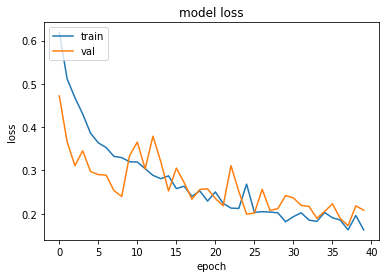

In [256]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


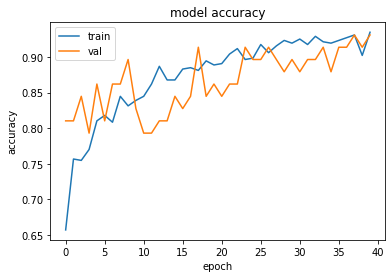

In [257]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [258]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 11ms/step - loss: 0.1958 - accuracy: 0.9315


[0.19583337008953094, 0.931506872177124]

In [275]:
from tensorflow.keras.models import load_model
model = load_model("models/best_model_hypertune.h5")
model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 9ms/step - loss: 0.1394 - accuracy: 0.9521


[0.13944657146930695, 0.9520547986030579]

In [276]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

In [277]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred))
print(" ")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96        81
         1.0       0.93      0.97      0.95        65

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146

 
[[76  5]
 [ 2 63]]


In [279]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("../results/best_model_hyptertune/results.csv")

In [280]:
y_pred_noTack_test = model.predict(X_noTack_massTest)
y_pred_noTack_test = np.round(y_pred_noTack_test)

In [281]:
print(classification_report(y_noTack_massTest, y_pred_noTack_test))
print(" ")
print(confusion_matrix(y_noTack_massTest, y_pred_noTack_test))

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      4766
         1.0       0.00      0.00      0.00         0

    accuracy                           0.89      4766
   macro avg       0.50      0.44      0.47      4766
weighted avg       1.00      0.89      0.94      4766

 
[[4232  534]
 [   0    0]]


In [282]:
report = classification_report(y_noTack_massTest, y_pred_noTack_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("../results/best_model_hyptertune/results_noTack_mass.csv")